## Ensemble Modeling Part 2

We are going to iterate through a collection of Machine Learning Classifiers including Logistic Regression, Random Forest, XGBoost, and CatBoost. We will also iterate through a series of hyperparameters for each model. Both of these steps are to find the optimimal performing model, based on F1 score.

All of this modeling will be done using just the numeric features of our dataset.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from itertools import cycle

import warnings
import os
import time
import math
import requests

import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('EPL_Updated.csv')

In [10]:
df.columns

Index(['Pinnacle Closing Home Win Odds', 'Pinnacle Closing Draw Odds',
       'Pinnacle Closing Away Win Odds', 'date', 'home_team', 'away_team',
       'week', 'date.1', 'home_team.1', 'home_xg', 'score', 'away_xg',
       'away_team.1', 'referee', 'game_id', 'home_team_elo', 'away_team_elo',
       'season', 'home_starters', 'away_starters', 'home_xG_to_date',
       'away_xG_to_date', 'home_xG_against_to_date', 'away_xG_against_to_date',
       'home_goals_scored', 'away_goals_scored', 'home_goals_scored_to_date',
       'away_goals_scored_to_date', 'home_goals_conceded_to_date',
       'away_goals_conceded_to_date', 'home_match_points', 'away_match_points',
       'home_points_to_date', 'away_points_to_date', 'match_points',
       'home_form', 'away_form', 'match_result'],
      dtype='object')

In [11]:
# Identifying columns that end with .1
columns_to_drop = [col for col in df.columns if col.endswith('.1')]

# Dropping these columns
epl_data_cleaned = df.drop(columns=columns_to_drop)

# Verifying the removal and updating the number of columns
num_columns_after_final_removal = epl_data_cleaned.shape[1]
columns_to_drop, num_columns_after_final_removal

(['date.1', 'home_team.1', 'away_team.1'], 35)

In [12]:
df = epl_data_cleaned

In [13]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss, make_scorer

# Correct way to select multiple columns
columns = [
    'Pinnacle Closing Home Win Odds', 'Pinnacle Closing Draw Odds', 
    'Pinnacle Closing Away Win Odds', 'home_team_elo', 'away_team_elo', 
    'home_xG_to_date', 'away_xG_to_date', 'home_xG_against_to_date', 
    'away_xG_against_to_date', 'home_goals_scored_to_date', 'away_goals_scored_to_date', 
    'home_goals_conceded_to_date', 'away_goals_conceded_to_date', 'home_points_to_date', 
    'away_points_to_date', 'home_form', 'away_form'
]

X = df[columns]
y = df['match_result']

# Splitting the data (adjust according to your dataset)
train_size = int(len(X) * 5/6)  # If last season is for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models and hyperparameters
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(),
    'SVC': SVC(probability=True)
}

param_grid = {
    'LogisticRegression': {'C': [0.025], 'penalty': ['l2']},
    'RandomForest': {
        'max_depth': [3]
    },
    'XGBClassifier': {
        'learning_rate': [.5, 0.75, 0.1],
        'n_estimators': [50, 75, 100],
        'lambda': [15],
        'alpha': [15]
    },
    'SVC': {'C': [0.01, 0.1, 0.5], 'kernel': ['rbf', 'linear']}
}

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Custom scorer for Brier Score
brier_scorer = make_scorer(brier_score_loss, greater_is_better=False)

# Dictionary to store the best model and parameters
best_models = {}
best_model_name = None
best_score = 1.0 

# Grid search for each model
for model_name, model in models.items():
    clf = GridSearchCV(model, param_grid[model_name], scoring=brier_scorer, cv=tscv)
    clf.fit(X_train_scaled, y_train)
    current_score = -clf.best_score_

    print(f"Model: {model_name}, Brier score: {current_score}")

    if current_score < best_score:
        best_score = current_score
        best_model_name = model_name
        best_models[model_name] = {'params': clf.best_params_, 'score': current_score}

# Check if a best model was found
if best_model_name is not None:
    print(f"\nBest model: {best_model_name}")
    print(f"Best model parameters: {best_models[best_model_name]['params']}")
    print(f"Best model Brier score: {best_models[best_model_name]['score']}")
else:
    print("No best model found. Please check the model configurations and data.")


Model: LogisticRegression, Brier score: nan
Model: RandomForest, Brier score: nan
Model: XGBClassifier, Brier score: nan
Model: SVC, Brier score: nan
No best model found. Please check the model configurations and data.


In [8]:
import pickle
# Save the scaler object
with open('logregscaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

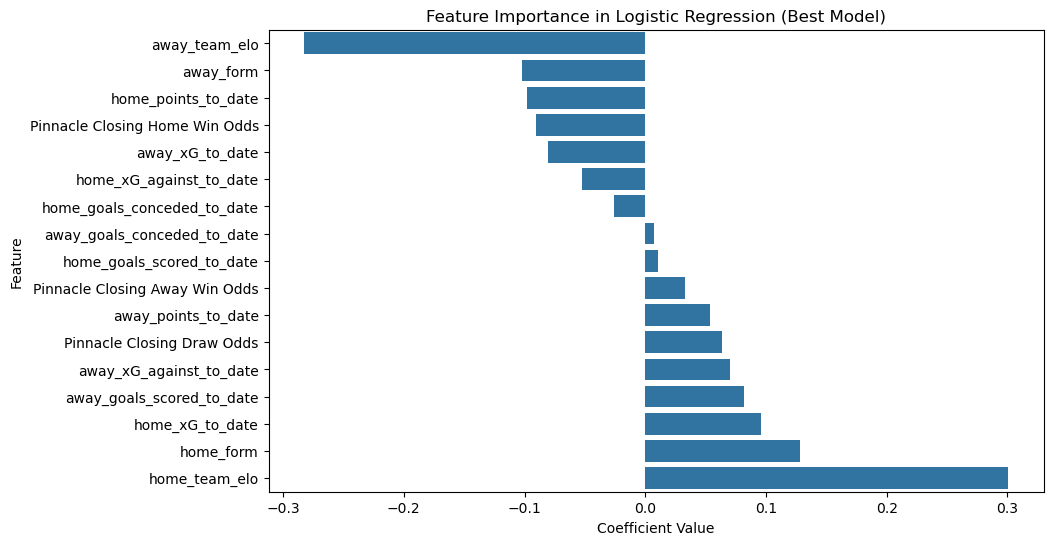

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check if the best model is Logistic Regression
if best_model_name == 'LogisticRegression':
    # Retrain the best Logistic Regression model on the entire training dataset
    best_params = best_models['LogisticRegression']['params']
    best_lr_model = LogisticRegression(**best_params)
    best_lr_model.fit(X_train_scaled, y_train)

    # Retrieve the coefficients and create a DataFrame for plotting
    feature_importance = pd.Series(best_lr_model.coef_[0], index=X.columns)
    sorted_importance = feature_importance.sort_values()

    # Plotting the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importance.values, y=sorted_importance.index)
    plt.title('Feature Importance in Logistic Regression (Best Model)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()


In [10]:
# Assuming Logistic Regression is the best model
best_params = best_models['LogisticRegression']['params']
best_model = LogisticRegression(**best_params)

# Train on the full training set
best_model.fit(X_train_scaled, y_train)


LogisticRegression(C=0.025)

In [11]:
# Make probability predictions on the test set
test_predictions_proba = best_model.predict_proba(X_test_scaled)
test_predictions_proba

array([[0.27647732, 0.25928222, 0.46424046],
       [0.22681785, 0.2361494 , 0.53703275],
       [0.20632977, 0.24550629, 0.54816394],
       ...,
       [0.37055239, 0.22876164, 0.40068597],
       [0.6803167 , 0.17351306, 0.14617024],
       [0.0888965 , 0.1245691 , 0.7865344 ]])

In [12]:
from sklearn.metrics import log_loss

# Evaluate the model using log loss
test_log_loss = log_loss(y_test, test_predictions_proba)
print(f"Log Loss on Test Set: {test_log_loss}")


Log Loss on Test Set: 0.9613272442610734


In [13]:
# Create a DataFrame from the probabilities
probabilities_df = pd.DataFrame(test_predictions_proba, columns=['Probability_Home_win', 'Probability_Draw', 'Probability_Away_win'])


In [14]:
# Concatenate with the original dataset
df_with_probabilities = pd.concat([df, probabilities_df], axis=1)
df_with_probabilities

,Pinnacle Closing Home Win Odds,Pinnacle Closing Draw Odds,Pinnacle Closing Away Win Odds,home_team_elo,away_team_elo,home_xG_to_date,away_xG_to_date,home_xG_against_to_date,away_xG_against_to_date,home_goals_scored_to_date,...,home_goals_conceded_to_date,away_goals_conceded_to_date,home_points_to_date,away_points_to_date,home_form,away_form,match_result,Probability_Home_win,Probability_Draw,Probability_Away_win
0,1.49,4.73,7.25,1848.286499,1716.994873,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0.0,0,0.276477,0.259282,0.464240
1,11.75,6.15,1.29,1583.799805,1866.807007,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0.0,2,0.226818,0.236149,0.537033
2,1.33,5.40,12.25,1909.399658,1628.988403,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0.0,2,0.206330,0.245506,0.548164
3,1.79,3.56,5.51,1642.862427,1475.799316,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0.0,2,0.110661,0.195446,0.693893
4,1.82,3.49,5.42,1751.501343,1662.613770,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0.0,0,0.392357,0.274732,0.332910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,1.65,4.26,5.31,1698.783569,1662.989624,44.3,37.8,65.2,62.7,33,...,57,70,33,39,1.0,1.2,0,NaN,NaN,NaN
2276,2.80,3.95,2.39,1664.983643,1802.854126,46.0,55.1,64.9,48.0,47,...,74,62,31,57,0.4,0.8,2,NaN,NaN,NaN
2277,2.11,4.01,3.29,1713.210815,1776.454712,49.1,47.8,62.0,51.6,49,...,67,53,31,40,0.6,1.2,0,NaN,NaN,NaN
2278,1.49,5.09,6.14,1866.215576,1736.953369,64.6,44.5,48.5,60.8,56,...,42,51,72,52,1.8,1.4,0,NaN,NaN,NaN


In [15]:
df = pd.read_csv('EPL_Updated.csv')

In [16]:
# Selecting the columns to add
columns_to_add = df[['week', 'date', 'score', 'home_team', 'away_team']]

# Merging using indexes (ensure both DataFrames have the same order and length)
final_df = pd.merge(df_with_probabilities, columns_to_add, left_index=True, right_index=True, how='left')



In [17]:
final_df

,Pinnacle Closing Home Win Odds,Pinnacle Closing Draw Odds,Pinnacle Closing Away Win Odds,home_team_elo,away_team_elo,home_xG_to_date,away_xG_to_date,home_xG_against_to_date,away_xG_against_to_date,home_goals_scored_to_date,...,away_form,match_result,Probability_Home_win,Probability_Draw,Probability_Away_win,week,date,score,home_team,away_team
0,1.49,4.73,7.25,1848.286499,1716.994873,0.0,0.0,0.0,0.0,0,...,0.0,0,0.276477,0.259282,0.464240,1,2017-08-11,4-3,arsenal,leicester
1,11.75,6.15,1.29,1583.799805,1866.807007,0.0,0.0,0.0,0.0,0,...,0.0,2,0.226818,0.236149,0.537033,1,2017-08-12,0-2,brighton,manchester city
2,1.33,5.40,12.25,1909.399658,1628.988403,0.0,0.0,0.0,0.0,0,...,0.0,2,0.206330,0.245506,0.548164,1,2017-08-12,2-3,chelsea,burnley
3,1.79,3.56,5.51,1642.862427,1475.799316,0.0,0.0,0.0,0.0,0,...,0.0,2,0.110661,0.195446,0.693893,1,2017-08-12,0-3,crystal palace,huddersfield
4,1.82,3.49,5.42,1751.501343,1662.613770,0.0,0.0,0.0,0.0,0,...,0.0,0,0.392357,0.274732,0.332910,1,2017-08-12,1-0,everton,stoke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,1.65,4.26,5.31,1698.783569,1662.989624,44.3,37.8,65.2,62.7,33,...,1.2,0,NaN,NaN,NaN,38,2023-05-28,1-0,everton,bournemouth
2276,2.80,3.95,2.39,1664.983643,1802.854126,46.0,55.1,64.9,48.0,47,...,0.8,2,NaN,NaN,NaN,38,2023-05-28,1-4,leeds,tottenham
2277,2.11,4.01,3.29,1713.210815,1776.454712,49.1,47.8,62.0,51.6,49,...,1.2,0,NaN,NaN,NaN,38,2023-05-28,2-1,leicester,west ham
2278,1.49,5.09,6.14,1866.215576,1736.953369,64.6,44.5,48.5,60.8,56,...,1.4,0,NaN,NaN,NaN,38,2023-05-28,2-1,manchester utd,fulham


In [18]:
csv_file_path = '/Users/lkimball/Desktop/Flatiron/CapstoneProject/logreg_preds.csv'
final_df.to_csv(csv_file_path, index=True)

In [19]:

with open('best_logreg_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)